## Connect with Drive

In [0]:
from google.colab import drive
drive.mount("/betogaona7")

In [1]:
%cd ./../betogaona7/My\ Drive/app/Distracted

/betogaona7/My Drive/app/Distracted


In [0]:
!ls 

data		  driver_imgs_list.csv	 test.tfrecord
Distracted.ipynb  kaggle.json		 train.tfrecord
DLNF-projects	  sample_submission.csv  Untitled0.ipynb


## Imports 

In [0]:
import os 
import random
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

#tf.enable_eager_execution()


## Create a TFRecord file

In [0]:
def imgs_with_labels(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append((os.path.join(path, file), path[-1:]))
      total += 1
  return data, total

data, total = imgs_with_labels("./data/test/")

In [0]:
img_path, label = data[random.randint(0, total)]
print("img: ", img_path, " label: ", label, " total: ", total )

img:  ./data/test/img_26623.jpg  label:  /  total:  79726


In [0]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfr_name = "test.tfrecord"
writer = tf.python_io.TFRecordWriter(tfr_name)

for img_path, img_class in data:
  img = np.array(Image.open(img_path))
  
  img_raw = open(img_path, 'rb').read()
  #label = int(img_class)
  path = str.encode(img_path)
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(img_raw),
      #'label': _int64_feature(label),
      'height': _int64_feature(img.shape[0]),
      'width': _int64_feature(img.shape[1]),
      'depth': _int64_feature(img.shape[2]),
      'path': _bytes_feature(path) }))
  #writer.write(example.SerializeToString())
#writer.close()

In [0]:
for example in tf.python_io.tf_record_iterator("test.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [0]:
!du -lh train.tfrecord
!du -sh ./data/train/

911M	train.tfrecord
913M	./data/train/


In [0]:
!du -lh test.tfrecord
!du -sh ./data/test/

3.2G	test.tfrecord
3.2G	./data/test/


## Build dataset 

In [0]:
def StateFarmDataset(image_size, tfrecord_file, shuffle_buffer_size, batch_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'label': tf.FixedLenFeature((), tf.int64),
                'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    # Reconstruct image 
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    image = tf.reshape(image, img_shape)
    
    # Normalize the image in the range 0 to 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Reshape image 
    image = tf.image.resize(image, [image_size, image_size])
        
    # One-hot encoding
    label = tf.one_hot(parsed_features['label'], 10, dtype=tf.int32)
    
    return image, label, parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(_parse_function)
  
  #dataset = dataset.batch(batch_size)
  #dataset = dataset.prefetch(1)
  
  return dataset         

In [19]:
total = 22424
dataset = StateFarmDataset(64, "train.tfrecord", total, 1)
print(dataset)

<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?, 10), (?,)), types: (tf.float32, tf.int32, tf.string)>


Label:  [[1 0 0 0 0 0 0 0 0 0]]
Img path:  [b'./data/train/c0/img_9270.jpg']
Img shape:  (1, 64, 64, 3)
Fine.


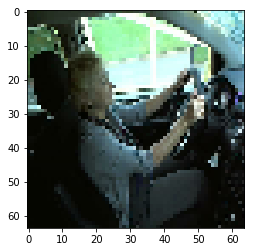

In [20]:
def test_normalization(image):
  assert image.max() <= 1 and image.min() >= 0,\
        'Incorect Range. {} to {} found'.format(image().min(), image.to_numpy().max())
  print("Fine.")
    


iterator = dataset.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, label, img_path = sess.run(record)
  print("Label: ", label)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  test_normalization(img[0])
  #print(img)
  plt.imshow(img[0])

In [14]:
"""
def make_iterator(total_imgs=22424, t_size=0.9, v_size=0.1, batch_size=128):
  tsize = int(t_size*total_imgs)
  vsize = int(v_size*total_imgs)
  
  dataset = StateFarmDataset(64, "train.tfrecord", total, batch_size)
  train_data= dataset.take(tsize)
  
  iterator = tf.data.Iterator.from_structure(output_types=train_data.output_types, output_shapes=train_data.output_shapes)
  training_init_op = iterator.make_initializer(train_data)
  return iterator, training_init_op

"""  
total = 22424
tsize = int(0.90*total)
vsize = int(0.10*total)
batch_size = 128

dataset = StateFarmDataset(64, "train.tfrecord", total, None)

train_data = dataset.take(tsize).batch(batch_size)
valid_data = dataset.skip(vsize).batch(batch_size)

handle = tf.placeholder(tf.string, shape=[])

train_iterator = tf.data.Iterator.from_string_handle(handle, train_data.output_types, train_data.output_shapes)

next_elements = valid_iterator.get_next()

train_iter = train_data.make_initializable_iterator()
valid_iter = valid_data.make_initializable_iterator()


print("Samples in training: ", tsize, "Number of trainining mini-batches: ", tsize/batch_size)
print("Samples in validation: ", vsize, "Number of validation mini-batches: ", vsize/batch_size)

#train_iterator = train_data.make_one_shot_iterator()
#valid_iterator = valid_data.make_initializable_iterator()

#next_elements = train_iterator.get_next()


#features, labels, _ = train_iterator.get_next()
#labels = tf.cast(labels, tf.int32)

#train_iterator = train_data.make_initializable_iterator()
#valid_iterator = valid_data.make_initializable_iterator()

#iterator = dataset.make_one_shot_iterator()
#features, labels, _ = iterator.get_next()
#print(train_data, tsize)
#print(valid_data, vsize)

Samples in training:  20181 Number of trainining mini-batches:  157.6640625
Samples in validation:  2242 Number of validation mini-batches:  17.515625


## Build network

In [0]:
def nn_input(img_shape):
  return tf.placeholder(tf.float32, shape=[None, img_shape[0], img_shape[1], img_shape[2]], name="x")

def nn_label(n_classes):
  return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def nn_keep_prob():
  return tf.placeholder(tf.float32, name='keep_prob')

def conv2d_maxpool(x_tensor, outs, conv_ksize, conv_strides, pool_ksize, pool_strides):
  weights = tf.Variable(tf.truncated_normal([conv_ksize, conv_ksize, int(x_tensor.shape[3]), outs]))
  bias = tf.Variable(tf.zeros([outs]))
  
  x = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides, conv_strides, 1], padding="SAME")
  x = tf.nn.bias_add(x, bias)
  x = tf.nn.relu(x)
  x = tf.nn.max_pool(x, ksize=[1, pool_ksize, pool_ksize, 1], strides=[1, pool_strides, pool_strides, 1], padding="SAME")
  return x

def flatten(x_tensor):
  dimensions = x_tensor.get_shape().as_list()
  img_flat_size = dimensions[1] * dimensions[2] * dimensions[3]
  return tf.reshape(x_tensor, [-1, img_flat_size])

def dense(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  x = tf.nn.relu(x)
  return x

def nn_output(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  return x

### Unit tests

In [0]:
def test_nn_input(neural_net_image_input):
    image_shape = (64, 64, 3)
    nn_inputs_out_x = nn_input(image_shape)

    assert nn_inputs_out_x.get_shape().as_list() == [None, image_shape[0], image_shape[1], image_shape[2]],\
        'Incorrect Image Shape.  Found {} shape'.format(nn_inputs_out_x.get_shape().as_list())

    assert nn_inputs_out_x.op.type == 'Placeholder',\
        'Incorrect Image Type.  Found {} type'.format(nn_inputs_out_x.op.type)

    assert nn_inputs_out_x.name == 'x:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_x.name)

    print("Image input tests passed.")


def test_nn_label(neural_net_label_input):
    n_classes = 10
    nn_inputs_out_y = nn_label(n_classes)

    assert nn_inputs_out_y.get_shape().as_list() == [None, n_classes],\
        'Incorrect Label Shape.  Found {} shape'.format(nn_inputs_out_y.get_shape().as_list())

    assert nn_inputs_out_y.op.type == 'Placeholder',\
        'Incorrect Label Type.  Found {} type'.format(nn_inputs_out_y.op.type)

    assert nn_inputs_out_y.name == 'y:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_y.name)

    print("Label input tests passed.")
    
def test_nn_keep_prob(neural_net_keep_prob_input):
    nn_inputs_out_k = nn_keep_prob()

    assert nn_inputs_out_k.get_shape().ndims is None,\
        'Too many dimensions found for keep prob.  Found {} dimensions.  It should be a scalar (0-Dimension Tensor).'.format(nn_inputs_out_k.get_shape().ndims)

    assert nn_inputs_out_k.op.type == 'Placeholder',\
        'Incorrect keep prob Type.  Found {} type'.format(nn_inputs_out_k.op.type)

    assert nn_inputs_out_k.name == 'keep_prob:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_k.name)
    
    print("Keep prob tests passed.")
    
def test_conv2d_maxpool(conv2d_maxpool):
    test_x = tf.placeholder(tf.float32, [None, 64, 64, 5])
    test_num_outputs = 10
    test_con_k = 2
    test_con_s = 4
    test_pool_k = 2
    test_pool_s = 2

    conv2d_maxpool_out = conv2d_maxpool(test_x, test_num_outputs, test_con_k, test_con_s, test_pool_k, test_pool_s)

    assert conv2d_maxpool_out.get_shape().as_list() == [None, 8, 8, 10],\
        'Incorrect Shape.  Found {} shape'.format(conv2d_maxpool_out.get_shape().as_list())

    print("Conv layer test passed.")
    
def test_flatten(flatten):
    test_x = tf.placeholder(tf.float32, [None, 10, 30, 6])
    flat_out = flatten(test_x)

    assert flat_out.get_shape().as_list() == [None, 10*30*6],\
        'Incorrect Shape.  Found {} shape'.format(flat_out.get_shape().as_list())

    print("Flatten test passed.")
    
def test_dense(fully_conn):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    fc_out = fully_conn(test_x, test_num_outputs)

    assert fc_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(fc_out.get_shape().as_list())

    print("Dense layer test passed.")


def test_output(output):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    output_out = output(test_x, test_num_outputs)

    assert output_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(output_out.get_shape().as_list())

    print("Output test passed")

    
tf.reset_default_graph() 

test_nn_input(nn_input)
test_nn_label(nn_label)
test_nn_keep_prob(nn_keep_prob)
test_conv2d_maxpool(conv2d_maxpool)
test_flatten(flatten)
test_dense(dense)
test_output(nn_output)

Image input tests passed.
Label input tests passed.
Keep prob tests passed.
Conv layer test passed.
Flatten test passed.
Dense layer test passed.
Output test passed


In [0]:
def model(x, keep_prob):
  conv1 = conv2d_maxpool(x, 128, 3, 1, pool_ksize=2, pool_strides=2)
  conv2 = conv2d_maxpool(conv1, 64, 3, 1, pool_ksize=2, pool_strides=2)
  conv3 = conv2d_maxpool(conv2, 32, 3, 1, pool_ksize=2, pool_strides=2)
  conv4 = conv2d_maxpool(conv3, 16, 3, 1, pool_ksize=2, pool_strides=2)
  
  fc1 = flatten(conv4)
  fc1 = dense(fc1, 1024)
  #fc1 = tf.nn.dropout(fc1, keep_prob)
  
  #fc2 = dense(fc1, 512)
  #fc2 = tf.nn.dropout(fc2, keep_prob)
  
  out = nn_output(fc1, 10)
  return out 

#tf.reset_default_graph()

x = nn_input((64, 64, 3))
y = nn_label(10)
keep_prob = nn_keep_prob()

logits = model(x, keep_prob)
logits = tf.identity(logits, name="logits")

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

In [22]:
def test_model(model):
    test_x = tf.placeholder(tf.float32, [None, 64, 64, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = model(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print("Model test passed.")
    
test_model(model)

Model test passed.


## Train

In [8]:
if not tf.test.gpu_device_name():
  print("You don't have the GPU activated")
else:
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

You don't have the GPU activated


### Single optimization

In [0]:
def train_nn(session, optimizer, keep_probability, feature_batch, label_batch):
  return session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})

def print_stats(session, feature_batch, label_batch, cost, accuracy):
  loss = sess.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
  
  valid_acc = sess.run(accuracy, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
  print("Loss: {:>10.4f} Accuracy: {:.6f}".format(loss, valid_acc))
  return None

In [30]:
from unittest.mock import MagicMock

def test_train_nn(train_neural_network):
    mock_session = tf.Session()
    test_x = np.random.rand(128, 64, 64, 3)
    test_y = np.random.rand(128, 10)
    test_k = np.random.rand(1)
    test_optimizer = tf.train.AdamOptimizer()

    mock_session.run = MagicMock()
    train_neural_network(mock_session, test_optimizer, test_k, test_x, test_y)

    assert mock_session.run.called, 'Session not used'

    print("Training test passed.")
    
test_train_nn(train_nn)

Training test passed.


In [0]:
epochs = 10 
keep_probability = 0.2

In [25]:
print("Checking training on a single batch... ")

#handle = tf.placeholder(tf.string, shape=[])
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  train_handle = sess.run(train_iter.string_handle())
  valid_handle = sess.run(valid_iter.string_handle())
  
  sess.run(valid_iter.initializer)
  sess.run(train_iter.initializer)
  
  for epoch in range(epochs):
    batch_i = 1
    min_batch = 0
    try:
      while True:
        features, labels, _ = sess.run(next_elements1, feed_dict ={handle1: train_handle})    
        train_nn(sess, optimizer, keep_probability, features, labels)
        print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, features, labels, cost, accuracy)
        min_batch += 1
    except tf.errors.OutOfRangeError:
      pass
    print(min_batch) # should return 158
  
  #x,y, _ = sess.run(next_elements, feed_dict = {handle: train_handle})
  #print(x.shape)
  #print("Training")
  #print(x[0], y[0])
  #break
  #x1, y2, _ = sess.run(next_elements, feed_dict = {handle: valid_handle})
  #print("Valid")
  #print(x1[0], y2[0])

Checking training on a single batch... 
Epoch  1, Batch 1:  Loss: 30895.8867 Accuracy: 0.164062
Epoch  1, Batch 1:  Loss: 32500.1074 Accuracy: 0.148438
Epoch  1, Batch 1:  Loss: 34314.8438 Accuracy: 0.101562
Epoch  1, Batch 1:  Loss: 30076.6289 Accuracy: 0.109375
Epoch  1, Batch 1:  Loss: 28660.2344 Accuracy: 0.070312
Epoch  1, Batch 1:  Loss: 22638.9258 Accuracy: 0.117188
Epoch  1, Batch 1:  Loss: 21014.5215 Accuracy: 0.132812
Epoch  1, Batch 1:  Loss: 16103.7051 Accuracy: 0.187500
Epoch  1, Batch 1:  Loss: 16626.7324 Accuracy: 0.171875
Epoch  1, Batch 1:  Loss: 15914.1719 Accuracy: 0.125000
Epoch  1, Batch 1:  Loss: 11709.0723 Accuracy: 0.179688
Epoch  1, Batch 1:  Loss: 11642.9414 Accuracy: 0.132812
Epoch  1, Batch 1:  Loss:  8758.2568 Accuracy: 0.187500
Epoch  1, Batch 1:  Loss:  7411.7930 Accuracy: 0.132812
Epoch  1, Batch 1:  Loss:  7970.1709 Accuracy: 0.187500
Epoch  1, Batch 1:  Loss:  7310.9751 Accuracy: 0.156250
Epoch  1, Batch 1:  Loss:  8808.0068 Accuracy: 0.132812
Epoch  1